In [190]:
import os
import sys
import json
import glob
import h5py
import tqdm
import time
import numpy as np
import scipy.signal
import scipy.interpolate
import scipy.io
import scipy.io.wavfile
import soundfile as sf
import soxr
import matlab.engine
import importlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import room_simulator
importlib.reload(room_simulator);


In [2]:
eng = matlab.engine.start_matlab();


In [4]:
brir = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=45,
    src_elev=-45,
    src_dist=1.4,
    buffer_pos=0,
    sr=44100,
    dur=0.5,
    eng=eng)

brir_near = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[10, 10, 10],
    head_pos_xyz=[5, 5, 5],
    head_azim=0,
    src_azim=45,
    src_elev=45,
    src_dist=1.4,
    buffer_pos=0,
    sr=44100,
    dur=0.5,
    eng=eng)


[room simulator] head_pos: [5, 5, 5], src_pos: [5.7, 5.7, 4.010050506338834], room_dim: [10, 10, 10]
[room simulator] time elapsed: 105.27656483650208 seconds
[room simulator] incorporated 0 leading zeros
[room simulator] head_pos: [5, 5, 5], src_pos: [5.7, 5.7, 5.989949493661166], room_dim: [10, 10, 10]
[room simulator] time elapsed: 3.2958171367645264 seconds
[room simulator] incorporated 0 leading zeros


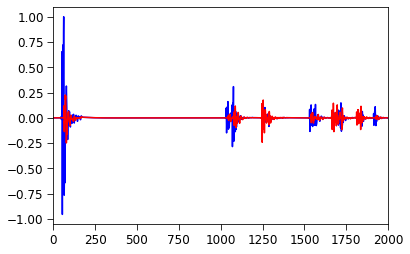

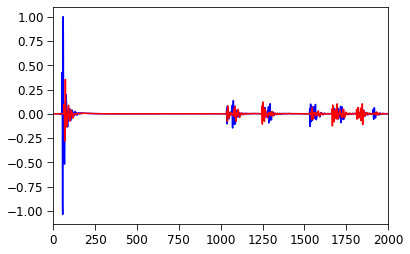

In [6]:
fig, ax = plt.subplots()
ax.plot(brir[:, 0] / brir.max(), 'b')
ax.plot(brir[:, 1] / brir.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()

fig, ax = plt.subplots()
ax.plot(brir_near[:, 0] / brir_near.max(), 'b')
ax.plot(brir_near[:, 1] / brir_near.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()


In [7]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr = sf.read(fn)
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
ipd.display(ipd.Audio(rate=sr, data=y))
print(sr, y.shape)


44100 (132300,)


In [8]:
y_spatial = util_stimuli.spatialize_sound(y, brir)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=True))

y_spatial = util_stimuli.spatialize_sound(y, brir_near)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=True))


(22050, 2) float64 (132300, 2) float64


(22050, 2) float64 (132300, 2) float64


In [191]:
def distance_to_wall(room_dim_xyz, head_pos_xyz, head_azim, src_azim, src_elev):
    """
    Helper function to find maximum possible source distance given room dimensions,
    head position, head azimuth, source azimuth (relative to head), and source
    elevation (relative to head).
    """
    azim = head_azim + src_azim
    elev = src_elev
    while azim < 0:
        azim += 360
    azim = azim % 360
    quadrant = int(azim / 90) + 1
    if quadrant == 1:
        rx = (room_dim_xyz[0] - head_pos_xyz[0]) / (np.cos(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
        ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
    elif quadrant == 2:
        rx = -head_pos_xyz[0] / (np.cos(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
        ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
    elif quadrant == 3:
        rx = -head_pos_xyz[0] / (np.cos(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
        ry = -head_pos_xyz[1] / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
    elif quadrant == 4:
        rx = (room_dim_xyz[0] - head_pos_xyz[0]) / (np.cos(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
        ry = -head_pos_xyz[1] / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))
    else:
        raise ValueError('INVALID ANGLE')
    if elev > 0:
        rz = (room_dim_xyz[2] - head_pos_xyz[2]) / np.sin(np.deg2rad(elev))
    elif elev < 0:
        rz = -head_pos_xyz[2] / np.sin(np.deg2rad(elev))
    else:
        rz = np.inf
    return min(rx, ry, rz)


In [ ]:
import room_simulator
importlib.reload(room_simulator);

for _ in range(300):
    np.random.seed(_)
    room_parameters = room_simulator.sample_room_parameters(verbose=False)
    head_parameters = room_simulator.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_azim = 0
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer_pos = 0
    for src_azim in range(0, 360, 15):
        for src_elev in range(-60, 61, 5):
            src_dist = distance_to_wall(room_dim_xyz, head_pos_xyz, head_azim, src_azim, src_elev)
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert room_simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid head position"
#             assert room_simulator.is_valid_position(src_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid source position"
            if (np.sum(np.isclose(src_pos_xyz, 0)) == 1) or (np.sum(np.isclose(src_pos_xyz, room_dim_xyz)) == 1):
                pass
            else:
                print(src_azim, src_elev, room_dim_xyz, src_pos_xyz)


/om2/user/msaddler/.conda/envs/matlab/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


30 30 [9.181887107492445, 20.147813552314354, 5.8145156138141845] [9.18183278 6.11399071 5.81451561]


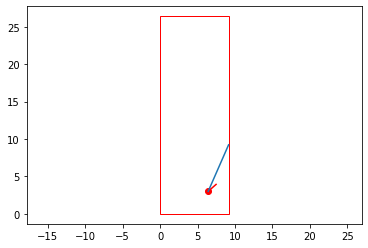

Checked src_azim: 25 = 24.99999999999999


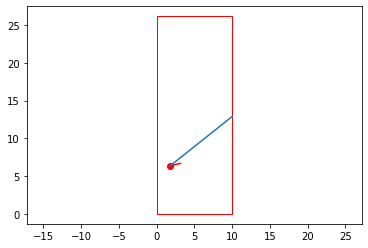

Checked src_azim: 25 = 25.000000000000004


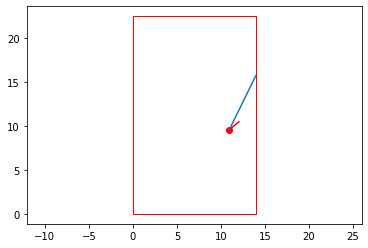

Checked src_azim: 25 = 24.99999999999999


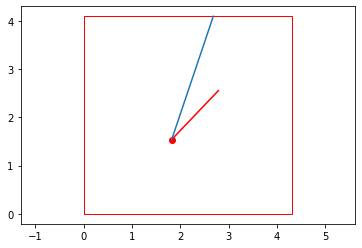

Checked src_azim: 25 = 25.000000000000004


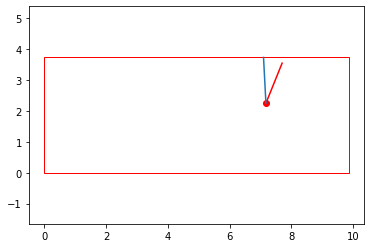

Checked src_azim: 25 = 25.000000000000004


In [201]:
for _ in range(5):
    room_parameters = room_simulator.sample_room_parameters(verbose=False)
    head_parameters = room_simulator.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    
    fig, ax = plt.subplots()
    rect = matplotlib.patches.Rectangle((0, 0), room_dim_xyz[0], room_dim_xyz[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.plot(head_pos_xyz[0], head_pos_xyz[1], 'ro')
    src_azim = 25
    src_elev = 5
    src_dist = distance_to_wall(room_dim_xyz, head_pos_xyz, head_azim=head_azim, src_azim=src_azim, src_elev=src_elev)
    dhx = 1.4 * np.cos(np.deg2rad(head_azim))
    dhy = 1.4 * np.sin(np.deg2rad(head_azim))
    dx = src_dist * np.cos(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    dy = src_dist * np.sin(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dhx], [head_pos_xyz[1], head_pos_xyz[1] + dhy], 'r-')
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dx], [head_pos_xyz[1], head_pos_xyz[1] + dy])
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
    vector1 = np.array([dx, dy])
    vector2 = np.array([dhx, dhy])
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.rad2deg(np.arccos(dot_product))
    print(f'Checked src_azim: {src_azim} = {angle}')


In [207]:
eng.quit()
